In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import quickMTF.sfr_mtf as sfr

%matplotlib inline

In [16]:
# algorithm parameters
supersampling = 4
show_plots = 5
mtf_index = 0.5
sequence=0
return_fig = False

diff_kernel = np.array([0.5, 0.0, -0.5])
diff_offset = 0.0
diff_ft = 2  # factor used in the correction of the numerical derivation

plot = True

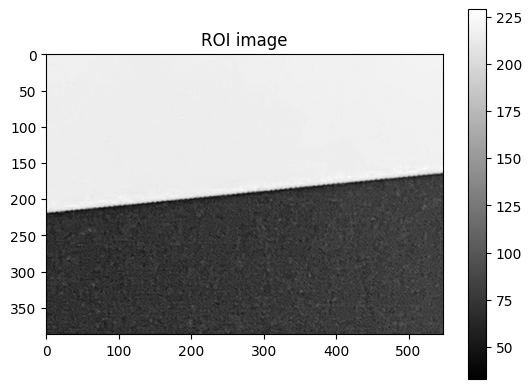

In [17]:
# load ROI image
image = np.load(r"..\quickMTF\sample_hori_edge.npy")
# image = np.load(r"..\quickMTF\sample_vert_edge.npy")
# image = np.load(r"..\quickMTF\sample.npy")
# image = np.load(r"C:\Users\Lucas\Desktop\for\for Lucas\sample.npy")

sample = image

if plot:
    fig, ax = plt.subplots()
    im = ax.imshow(image, cmap='gray')
    fig.colorbar(im, ax=ax)
    plt.title("ROI image")
    plt.show()

original ROI
Rot90 ROI
Rotated: True
[-2.59553347e-06  1.02084325e-01  1.66790687e+02] 0.1006645685400411 166.9203582384722 5.748290624421164
[0.0, np.float64(0.1006645685400411), np.float64(166.9203582384722)]
(548, 387)
True
(548, 387)
(548, 387)
(1756,)
78 [797, 957]


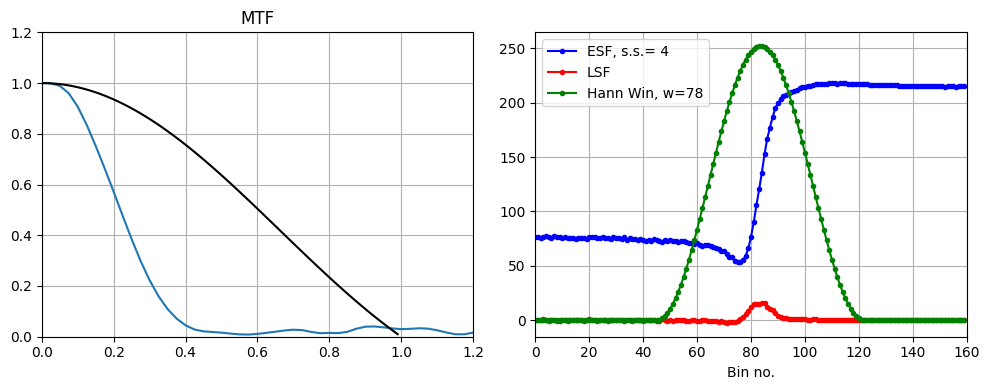

In [15]:
# calculate centroids for the edge transition of each row
print("original ROI")
sample_diff = sfr.differentiate(image, diff_kernel)
sample_centr, sample_win, sample_sum_arr, sample_sum_arr_x = sfr.centroid(sample_diff, verbose=True)
sample_centr = sample_centr + diff_offset
if plot:
    sfr.plot_centroid_and_stats(sample_diff, sample_centr, sample_win, sample_sum_arr, sample_sum_arr_x)

# calculate centroids also for the 90deg right rotated image
print("Rot90 ROI")
image_rot90 = image.T[:, ::-1]  # rotate by transposing and mirroring
sample_diff_rot90 = sfr.differentiate(image_rot90, diff_kernel)
sample_centr_rot90, sample_win_rot90, sample_sum_arr_rot90, sample_sum_arr_x_rot90 = sfr.centroid(sample_diff_rot90, verbose=True)
sample_centr_rot90 = sample_centr_rot90 + diff_offset

if plot:
    sfr.plot_centroid_and_stats(sample_diff_rot90, sample_centr_rot90, sample_win_rot90, sample_sum_arr_rot90, sample_sum_arr_x_rot90)

# Use rotated image if it results in fewer rows without edge transitions

image_for_mtf, diff_for_mtf, centroid_for_mtf, win_for_mtf, sum_arr_for_mtf, sum_arr_x_for_mtf, rotated = sfr.pick_valid_roi_rotation(image, sample_diff, sample_centr, sample_win, sample_sum_arr, sample_sum_arr_x, image_rot90, sample_diff_rot90, sample_centr_rot90, sample_win_rot90, sample_sum_arr_rot90, sample_sum_arr_x_rot90)

print(f"Rotated: {rotated}")
if plot:
    sfr.plot_centroid_and_stats(diff_for_mtf, centroid_for_mtf, win_for_mtf, sum_arr_for_mtf, sum_arr_x_for_mtf)

# find edge
pcoefs, slope, offset, angle, idx, patch_shape, centr = sfr.find_edge(centroid_for_mtf, image_for_mtf.shape, rotated, angle=None, verbose=True)
print(pcoefs, slope, offset, angle)

if abs(angle) < 0.9 : # ingore the less than 0.9 degree slant edge
     print("angle is less than 0.9 degs")

quadratic_fit = False

pcoefs = [0.0, slope, offset] if not quadratic_fit else pcoefs
print(pcoefs)
print(image_for_mtf.shape)
print(rotated)
print(patch_shape)

if plot:
    sfr.plot_edge_and_stats(image_for_mtf, pcoefs, slope, offset, angle, idx, patch_shape, centr, rotated)

# Calculate distance (with sign) from each point (x, y) in the
# image patch "data" to the slanted edge
dist = sfr.calc_distance(image_for_mtf.shape, pcoefs, quadratic_fit=quadratic_fit)
print(dist.shape)

if plot:
    sfr.plot_dist_and_stats(dist)

# ESF
esf = sfr.project_and_bin(image_for_mtf, dist, supersampling)  # edge spread function
print(esf.shape)
if esf is False:
    print("esf is invalid")

if plot:
    sfr.plot_esf_and_stats(esf)

## LSF
lsf = sfr.differentiate(esf, diff_kernel)  # line spread function

if plot:
    sfr.plot_lsf_and_stats(lsf[0:-1])

## Hann window
hann_win, hann_width, idx = sfr.filter_window(lsf[0:-1], supersampling)  # define window to be applied on LSF
if hann_width >350:  # sorting out no slant edge
    print("wrong!")

print(hann_width, idx)
if plot:
    sfr.plot_filter_window_and_stats(hann_win)

## MTF
mtf = sfr.calc_mtf(lsf[0:-1], hann_win, idx, supersampling, diff_ft)

sfr.plot_mtf_and_stats(mtf, esf, hann_win, hann_width, lsf, idx, supersampling)